In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import SGDRegressor

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
from sklearn.linear_model import Ridge

In [9]:
from sklearn.linear_model import RidgeCV

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
from sklearn.metrics import mean_squared_error

In [11]:
from sklearn.linear_model import Ridge

In [12]:
from sklearn.linear_model import LassoCV

### Data cleaning 

In [13]:
df_train = pd.read_csv('Data/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Cleaning data, to be modelled for training data

In [14]:
#Fucntion to clean and process Train data
def clean_data_process(df):    
    ### Data cleaning 
    df1 = df.copy()
    ### Remove outliers
    df_numeric = df1.select_dtypes(include=['number'])
    df_numeric
    scaler1 = StandardScaler()
    
    norm_data1 = scaler1.fit_transform(df_numeric)
    norm1_df = pd.DataFrame(norm_data1, columns=df_numeric.columns)
    outliers_z_plus3 = norm1_df[norm1_df > 3].any(axis=1)
    outliers_z_minus3 = norm1_df[norm1_df < -3].any(axis=1)
    all_z_outliers = outliers_z_plus3 | outliers_z_minus3 
    #plt.scatter(df_numeric['SalePrice'], df_numeric['LotArea'])
    z_outlier_mask = norm1_df.abs() > 3
    z_outlier_counts = z_outlier_mask.sum(axis=1)
    multi_outlier_indices = z_outlier_counts[z_outlier_counts >= 2].index
    #outlier bond
    lower_bounds = norm1_df.quantile(0.005)
    upper_bounds = norm1_df.quantile(0.995)
    rows_to_drop = []
    for idx in multi_outlier_indices:
        offending_cols = z_outlier_mask.columns[z_outlier_mask.loc[idx]]
        if all((norm1_df.loc[idx, col] < lower_bounds[col]) or (norm1_df.loc[idx, col] > upper_bounds[col]) for col in offending_cols):
            rows_to_drop.append(idx)
    rows_to_drop
    df1 = df.drop(index=rows_to_drop)
    df1    
    #### Fixing missing values
    #lot frontage clean
    bins = [1000, 10000, 50000, 250000]
    labels = ['Small', 'Medium', 'Large']
    df1['LotAreaBin'] = pd.cut(df1['LotArea'], bins=bins, labels=labels, right=False)
    
    # Calculate median LotFrontage per LotArea bin
    
    median_frontage = df1.groupby('LotAreaBin')['LotFrontage'].median()
    median_frontage
    
    #Finding mean without binning
    df1['LotFrontage'].mean()
    # Impute missing LotFrontage based on LotAreaBin
    
    # Impute missing LotFrontage based on LotAreaBin
    df1['LotFrontage'] = df1.apply(
    lambda row: median_frontage.get(row['LotAreaBin'], row['LotFrontage'])
    if pd.isnull(row['LotFrontage']) else row['LotFrontage'], 
    axis=1)
    
    df1['LotFrontage'].mean()
    modemva = df1['MasVnrArea'].mode()[0]
    modemva
    
    #where MasVnrArea doesnt have value
    df1[df1['MasVnrArea'].isna()]#['MasVnrArea']
    
    #replacing MasVnrArea with the mode number
    df1['MasVnrArea'].fillna(modemva, inplace=True)
    #df_train1['MasVnrArea'].value_counts(dropna=False)
    df1['has_basement'] = df1['BsmtQual'].notna().astype(int)
    df1.loc[df1[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().all(axis=1)]
    
    #df_train1.fillna(value=fill_values, inplace=True)
    df1[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().sum()
    
    bsmtmap = {
    'Ex': 5,	
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'Av': 3,	
    'Mn': 2,
    'No': 1,
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,	
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    }
    
    cols_to_map = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for col in cols_to_map:
        df1[col] = df1[col].map(bsmtmap).fillna(0)
    df1[cols_to_map].isna().sum()
    
    #Electrical 1 FireplaceQu  686 GarageType  78 GarageYrBlt  78 GarageFinish  78 GarageQual  
    #78 GarageCond  78 PoolQC  1443 Fence  1172 MiscFeature  1396

    df1.columns
    df1['Electrical'].fillna(df1['Electrical'].mode()[0], inplace=True)
    df1['FireplaceQu'] = df1['FireplaceQu'].map(bsmtmap).fillna(0)    
    #df_train1['FireplaceQu'].value_counts(dropna=False)
    
    #GarageType  78 GarageYrBlt  78 GarageFinish  78 GarageQual  78 GarageCond  78
    df1[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']]
    
    df1[df1[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].isna().any(axis=1)][['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']]
    
    df1['has_garage'] = df1['GarageType'].notna().astype('int')
    gara_fini = {
       'Ex': 5,	
       'Gd': 4,
       'TA': 3,
       'Fa': 2,
       'Po': 1,
       'Unf':1,
       'RFn':2, 
       'Fin':3   
    }
    for col in ['GarageFinish','GarageQual','GarageCond']:
        df1[col] = df1[col].map(gara_fini).fillna(0)
        #print(df1[col].value_counts(dropna=False))
    
    df1['GarageYrBlt'] = df1['GarageYrBlt'].fillna(0)
    
    
    ### GarageType one hot encoding
    
    df1['GarageType'] = df1['GarageType'].fillna('NoGarage')    
    df1['GarageType'].value_counts(dropna=False)
    garage_dummies = pd.get_dummies(df1['GarageType'], drop_first = True, prefix='GarageType').astype(int)
    df1 = pd.concat([df1, garage_dummies], axis=1)
    df1.drop('GarageType', axis=1, inplace=True)
    #for cols in df1.columns[df1.isna().sum()>0]:
     #   print(f"{cols} ", df1[cols].isna().sum())    
    #PoolQC  1443 Fence  1172 MiscFeature  1396 
    df1['PoolQC'] = df1['PoolQC'].map(gara_fini).fillna(0) 
    df1['has_fence'] = df1['Fence'].notna().astype(int)
    fence_map = {
       'GdPrv':4,
       'MnPrv':3,
       'GdWo':2,
       'MnWw':1
    }
    df1['Fence'] = df1['Fence'].map(fence_map).fillna(0)
    df1['MiscFeature'] = df1['MiscFeature'].fillna('NoMisc')
    rare = df1['MiscFeature'].value_counts()[lambda x: x<5].index
    df1['MiscFeature'] = df1['MiscFeature'].replace(rare, 'OtherMisc')
    misc_dummies = pd.get_dummies(df1['MiscFeature'], drop_first=True, prefix='MiscFeature').astype(int)
    df1 = pd.concat([df1, misc_dummies], axis=1).drop('MiscFeature', axis=1)
    df1['Alley'] = df1['Alley'].fillna('NoAlley')
    alley_dummies = pd.get_dummies(df1['Alley'], prefix="Alley", drop_first=True).astype(int)
    df1 = pd.concat([df1, alley_dummies], axis=1)
    df1.drop('Alley', axis=1, inplace=True)
    df1['MasVnrType'] = df1['MasVnrType'].fillna('None')
    masvnr_dummies = pd.get_dummies(df1['MasVnrType'], prefix='MasVnrType', drop_first=True).astype(int)
    df1 = pd.concat([df1, masvnr_dummies], axis=1).drop('MasVnrType', axis=1)
    df1
    df_objects = df1.select_dtypes(include=['object'])

    del df1['LotAreaBin']
    
    gara_fini
    #['ExterQual' 'ExterCond', 'HeatingQC', 'KitchenQual']
    for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']:
        df1[col] = df1[col].map(gara_fini) 
    
    elec_map = {
        'SBrkr':4,
        'FuseA':3,
        'FuseF':2,
        'FuseP':1,
        'Mix':2.5
    }

    df1['Electrical'] = df1['Electrical'].map(elec_map)
    func_map = {
       'Typ':8,
       'Min1':7,
       'Min2':6,
       'Mod':5,
       'Maj1':4,
       'Maj2':3,
       'Sev':2,
       'Sal':1
    }
    
    df1['Functional'] #= df_train2['Functional']
    df1['Functional'] = df1['Functional'].map(func_map)
    df1['CentralAir'] = df1['CentralAir'].map({'Y':1, 'N':0})
    street_dummies = pd.get_dummies(df1['Street'], prefix='Street', drop_first=True).astype(int)
    df1 = pd.concat([df1, street_dummies], axis=1)
    df1.drop('Street', axis=1, inplace=True)

    cat_encod1 = ['MSZoning', 'LotShape', 'LandContour', 'Utilities',
           'LotConfig', 'LandSlope','BldgType', 'PavedDrive', ]
    for col in cat_encod1:
        df_dummies = pd.get_dummies(df1[col], prefix=col, drop_first = True).astype(int)
        df1 = pd.concat([df1, df_dummies],axis=1)
        df1.drop(col, axis=1, inplace=True)
    df1
    
    for col in ['SaleCondition', 'HouseStyle']:
        df_dummies = pd.get_dummies(df1[col], prefix=col, drop_first = True).astype(int)
        df1 = pd.concat([df1, df_dummies],axis=1)
        df1.drop(col, axis=1, inplace=True)
    
    df_all_encode = df1.copy()
    
    for col in df_all_encode.select_dtypes(include=['object']):
        df_dummies = pd.get_dummies(df_all_encode[col], prefix=col, drop_first = True).astype(int)
        df_all_encode = pd.concat([df_all_encode, df_dummies],axis=1)
        df_all_encode.drop(col, axis=1, inplace=True)
    df_all_encode
    
    #df_thresh = df1.copy()
    #for col in df_thresh.select_dtypes(include=['object']).columns:
     #   rare = df_thresh[col].value_counts()[lambda x: x<10].index
      #  df_thresh[col] = df_thresh[col].replace(rare, f"other_{col}")
       # dd_dummies = pd.get_dummies(df_thresh[col], prefix=col, drop_first=True).astype(int)
        #df_thresh = pd.concat([df_thresh, dd_dummies], axis=1).drop(col, axis=1)
    
    df_all_encode1 = df_all_encode.copy()
    #df_thresh.corr()
    
    ### Correlation analysis
    corr = df_all_encode.corr().abs()
    #Mask out the lower triangle and the diagonal
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    high_corr = corr.where(mask)
    #Stack and filter for |r| ≥ threshold
    threshold = 0.8
    loopy_pairs = (
        high_corr
          .stack()
          .loc[lambda x: x >= threshold]
          .sort_values(ascending=False)
    )
    
    loopy_pairs
    
    
    df_all_encode =  df_all_encode.loc[:, ~df_all_encode.T.duplicated()]
    df_all_encode
    
    thresh_to_drop = ['Street_Pave', 'GarageType_NoGarage', 'has_garage', 'GarageYrBlt', 'SaleCondition_Partial', 'Exterior2nd_VinylSd', 'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'has_fence', 'GarageCond', 'RoofStyle_Hip', 'PoolQC', 'Exterior2nd_HdBoard', 'GarageCars', 'has_basement', 'Exterior2nd_Wd Sdng', 'FireplaceQu', 'Neighborhood_Somerst', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'MSZoning_RM', 'MasVnrType_None', 'Foundation_Slab']    
    df_all_encode[thresh_to_drop]
    
    df_all_encode3 = df_all_encode.copy()
    df_all_encode.drop(thresh_to_drop, axis=1, inplace=True)
    
    corr = df_all_encode.corr().abs()
    #Mask out the lower triangle and the diagonal
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    high_corr = corr.where(mask)
    #Stack and filter for |r| ≥ threshold
    threshold = 0.8
    loopy_pairs = (
        high_corr
          .stack()
          .loc[lambda x: x >= threshold]
          .sort_values(ascending=False)
    )
    
    loopy_pairs 
    print("loopy pairs", loopy_pairs)
    ### now the modeling begins
    ### Continuous columns
    
    continuous_cols = [
        col for col in df_all_encode.select_dtypes(include=['int64','float64']).columns
        if df_all_encode[col].nunique() > 2
    ]
    try:
        continuous_cols.remove('Id')
        continuous_cols.remove('SalePrice')
    except:
        pass
    continuous_cols
    return df_all_encode, continuous_cols

#### Data cleaning for test data, no data removal as all rows must be predicted

In [15]:
#To clean and process test data
def process_test_data(df):     
    df1 = df.copy()
    #### Fixing missing values
    #lot frontage clean
    bins = [1000, 10000, 50000, 250000]
    labels = ['Small', 'Medium', 'Large']
    df1['LotAreaBin'] = pd.cut(df1['LotArea'], bins=bins, labels=labels, right=False)
    
    # Calculate median LotFrontage per LotArea bin
    median_frontage = df1.groupby('LotAreaBin')['LotFrontage'].median()
    median_frontage
    
    #Finding mean without binning
    df1['LotFrontage'].mean()
    # Impute missing LotFrontage based on LotAreaBin
    df1['LotFrontage'] = df1.apply(
    lambda row: median_frontage.get(row['LotAreaBin'], row['LotFrontage'])
    if pd.isnull(row['LotFrontage']) else row['LotFrontage'], 
    axis=1)
    
    df1['LotFrontage'].mean()
    modemva = df1['MasVnrArea'].mode()[0]
    modemva
    
    #where MasVnrArea doesnt have value
    df1[df1['MasVnrArea'].isna()]#['MasVnrArea']
    
    #replacing MasVnrArea with the mode number
    df1['MasVnrArea'].fillna(modemva, inplace=True)
    #df_train1['MasVnrArea'].value_counts(dropna=False)
    df1['has_basement'] = df1['BsmtQual'].notna().astype(int)
    df1.loc[df1[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().all(axis=1)]
    
    #df_train1.fillna(value=fill_values, inplace=True)
    df1[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().sum()
    bsmtmap = {
    'Ex': 5,	
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'Av': 3,	
    'Mn': 2,
    'No': 1,
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,	
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    }
    
    cols_to_map = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for col in cols_to_map:
        df1[col] = df1[col].map(bsmtmap).fillna(0)
    df1[cols_to_map].isna().sum()
    
    #Electrical 1 FireplaceQu  686 GarageType  78 GarageYrBlt  78 GarageFinish  78 GarageQual  
    #78 GarageCond  78 PoolQC  1443 Fence  1172 MiscFeature  1396

    df1.columns
    df1['Electrical'].fillna(df1['Electrical'].mode()[0], inplace=True)
    df1['FireplaceQu'] = df1['FireplaceQu'].map(bsmtmap).fillna(0)    
    #df_train1['FireplaceQu'].value_counts(dropna=False)
    
    #GarageType  78 GarageYrBlt  78 GarageFinish  78 GarageQual  78 GarageCond  78
    df1[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']]
    df1[df1[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].isna().any(axis=1)][['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']]
    df1['has_garage'] = df1['GarageType'].notna().astype('int')
    gara_fini = {
       'Ex': 5,	
       'Gd': 4,
       'TA': 3,
       'Fa': 2,
       'Po': 1,
       'Unf':1,
       'RFn':2, 
       'Fin':3   
    }
    for col in ['GarageFinish','GarageQual','GarageCond']:
        df1[col] = df1[col].map(gara_fini).fillna(0)
        #print(df1[col].value_counts(dropna=False))
    
    df1['GarageYrBlt'] = df1['GarageYrBlt'].fillna(0)
    ### GarageType one hot encoding
    df1['GarageType'] = df1['GarageType'].fillna('NoGarage')    
    df1['GarageType'].value_counts(dropna=False)
    garage_dummies = pd.get_dummies(df1['GarageType'], drop_first = True, prefix='GarageType').astype(int)
    df1 = pd.concat([df1, garage_dummies], axis=1)
    df1.drop('GarageType', axis=1, inplace=True) 
    df1['PoolQC'] = df1['PoolQC'].map(gara_fini).fillna(0) 
    df1['has_fence'] = df1['Fence'].notna().astype(int)
    fence_map = {
       'GdPrv':4,
       'MnPrv':3,
       'GdWo':2,
       'MnWw':1
    }
    df1['Fence'] = df1['Fence'].map(fence_map).fillna(0)
    df1['MiscFeature'] = df1['MiscFeature'].fillna('NoMisc')
    rare = df1['MiscFeature'].value_counts()[lambda x: x<5].index
    df1['MiscFeature'] = df1['MiscFeature'].replace(rare, 'OtherMisc')
    misc_dummies = pd.get_dummies(df1['MiscFeature'], drop_first=True, prefix='MiscFeature').astype(int)
    df1 = pd.concat([df1, misc_dummies], axis=1).drop('MiscFeature', axis=1)
    df1['Alley'] = df1['Alley'].fillna('NoAlley')
    alley_dummies = pd.get_dummies(df1['Alley'], prefix="Alley", drop_first=True).astype(int)
    df1 = pd.concat([df1, alley_dummies], axis=1)
    df1.drop('Alley', axis=1, inplace=True)
    df1['MasVnrType'] = df1['MasVnrType'].fillna('None')
    masvnr_dummies = pd.get_dummies(df1['MasVnrType'], prefix='MasVnrType', drop_first=True).astype(int)
    df1 = pd.concat([df1, masvnr_dummies], axis=1).drop('MasVnrType', axis=1)
    df1
    df_objects = df1.select_dtypes(include=['object'])

    del df1['LotAreaBin']
    
    gara_fini
    #['ExterQual' 'ExterCond', 'HeatingQC', 'KitchenQual']
    for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']:
        df1[col] = df1[col].map(gara_fini) 
    
    elec_map = {
        'SBrkr':4,
        'FuseA':3,
        'FuseF':2,
        'FuseP':1,
        'Mix':2.5
    }

    df1['Electrical'] = df1['Electrical'].map(elec_map)
    
    func_map = {
       'Typ':8,
       'Min1':7,
       'Min2':6,
       'Mod':5,
       'Maj1':4,
       'Maj2':3,
       'Sev':2,
       'Sal':1
    }
    
    df1['Functional'] #= df_train2['Functional']
    df1['Functional'] = df1['Functional'].map(func_map)
    df1['CentralAir'] = df1['CentralAir'].map({'Y':1, 'N':0})
    street_dummies = pd.get_dummies(df1['Street'], prefix='Street', drop_first=True).astype(int)
    df1 = pd.concat([df1, street_dummies], axis=1)
    df1.drop('Street', axis=1, inplace=True)

    cat_encod1 = ['MSZoning', 'LotShape', 'LandContour', 'Utilities',
           'LotConfig', 'LandSlope','BldgType', 'PavedDrive', ]
    for col in cat_encod1:
        df_dummies = pd.get_dummies(df1[col], prefix=col, drop_first = True).astype(int)
        df1 = pd.concat([df1, df_dummies],axis=1)
        df1.drop(col, axis=1, inplace=True)
    df1
    
    for col in ['SaleCondition', 'HouseStyle']:
        df_dummies = pd.get_dummies(df1[col], prefix=col, drop_first = True).astype(int)
        df1 = pd.concat([df1, df_dummies],axis=1)
        df1.drop(col, axis=1, inplace=True)
    
    df_all_encode = df1.copy()
    
    for col in df_all_encode.select_dtypes(include=['object']):
        df_dummies = pd.get_dummies(df_all_encode[col], prefix=col, drop_first = True).astype(int)
        df_all_encode = pd.concat([df_all_encode, df_dummies],axis=1)
        df_all_encode.drop(col, axis=1, inplace=True)
    df_all_encode
    
    #df_thresh = df1.copy()
    #for col in df_thresh.select_dtypes(include=['object']).columns:
     #   rare = df_thresh[col].value_counts()[lambda x: x<10].index
      #  df_thresh[col] = df_thresh[col].replace(rare, f"other_{col}")
       # dd_dummies = pd.get_dummies(df_thresh[col], prefix=col, drop_first=True).astype(int)
        #df_thresh = pd.concat([df_thresh, dd_dummies], axis=1).drop(col, axis=1)
    
    df_all_encode1 = df_all_encode.copy()
    #df_thresh.corr()
    
    ### Correlation analysis
    corr = df_all_encode.corr().abs()
    #Mask out the lower triangle and the diagonal
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    high_corr = corr.where(mask)
    #Stack and filter for |r| ≥ threshold
    threshold = 0.8
    loopy_pairs = (
        high_corr
          .stack()
          .loc[lambda x: x >= threshold]
          .sort_values(ascending=False)
    )
    
    loopy_pairs
    
    
    df_all_encode =  df_all_encode.loc[:, ~df_all_encode.T.duplicated()]
    df_all_encode
    
    thresh_to_drop = ['Street_Pave', 'GarageType_NoGarage', 'has_garage', 'GarageYrBlt', 'SaleCondition_Partial', 'Exterior2nd_VinylSd', 'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'has_fence', 'GarageCond', 'RoofStyle_Hip', 'PoolQC', 'Exterior2nd_HdBoard', 'GarageCars', 'has_basement', 'Exterior2nd_Wd Sdng', 'FireplaceQu', 'Neighborhood_Somerst', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'MSZoning_RM', 'MasVnrType_None', 'Foundation_Slab']    
    df_all_encode[thresh_to_drop]
    
    df_all_encode3 = df_all_encode.copy()
    
    df_all_encode.drop(thresh_to_drop, axis=1, inplace=True)
    
    #df_thresh.drop(['has_garage', 'GarageYrBlt'], axis=1, inplace=True)
    #has now been included in cols to drop
    corr = df_all_encode.corr().abs()
    #Mask out the lower triangle and the diagonal
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    high_corr = corr.where(mask)
    #Stack and filter for |r| ≥ threshold
    threshold = 0.8
    loopy_pairs = (
        high_corr
          .stack()
          .loc[lambda x: x >= threshold]
          .sort_values(ascending=False)
    )
    
    loopy_pairs 
    print("loopy pairs", loopy_pairs)
    ### now the modeling begins
    
    ### Continuous columns
    continuous_cols = [
        col for col in df_all_encode.select_dtypes(include=['int64','float64']).columns
        if df_all_encode[col].nunique() > 2
    ]
    try:
        continuous_cols.remove('Id')
        continuous_cols.remove('SalePrice')
    except:
        pass
    #del df_all_encode['Id']
    continuous_cols
    return df_all_encode, continuous_cols

In [16]:
X, continuous_cols = clean_data_process(df_train)

loopy pairs Series([], dtype: float64)


(array([146., 720., 372., 131.,  51.,  19.,   4.,   3.,   1.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

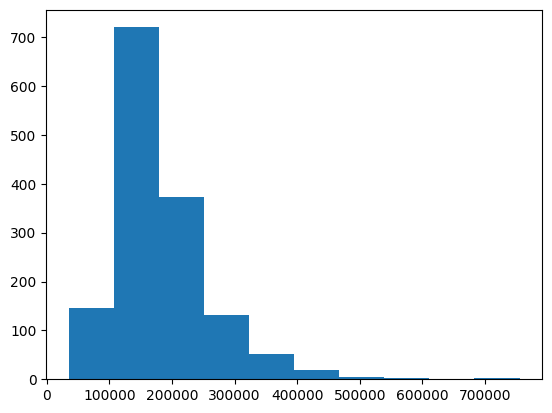

In [17]:
plt.hist(X['SalePrice'])

Text(0.5, 1.0, 'Normalized Sale Price')

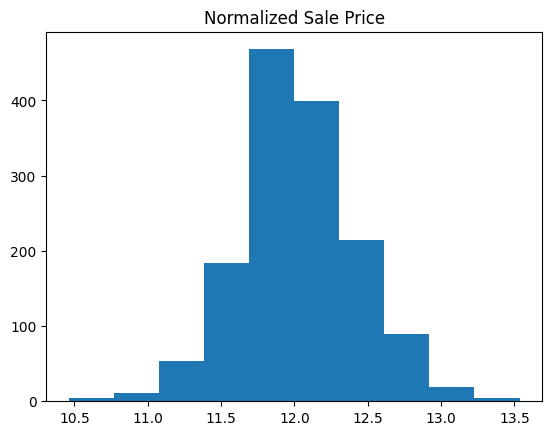

In [18]:
#noramlized saleprice using log
#the normalized saleprice is a better curve than the ordinary saleprice so we use the transformed saleprice
#to train the model
plt.hist(np.log1p(X['SalePrice']))
plt.title('Normalized Sale Price')

In [19]:
Y  = X['SalePrice']

In [20]:
X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=0.20, random_state=42)

In [21]:
continuous_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'Electrical',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'GarageFinish',
 'GarageArea',
 'GarageQual',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold']

In [22]:
X_train


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_OthW,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1310,1311,20,100.0,17500,7,8,1959,2002,0.0,4,...,0,0,0,0,0,0,0,0,0,1
1295,1296,20,70.0,8400,5,5,1968,1968,168.0,3,...,0,0,0,0,0,0,0,0,0,1
1043,1044,60,86.0,11839,7,5,1990,1990,99.0,3,...,0,0,0,0,0,0,0,0,0,1
419,420,20,65.0,8450,5,6,1968,1968,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1174,1175,70,80.0,16560,6,8,1932,1950,0.0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1104,20,79.0,8910,6,6,1959,1959,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1138,1139,20,60.0,9819,6,5,1977,1977,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1303,1304,20,73.0,8688,7,5,2005,2005,228.0,4,...,0,0,0,0,0,0,0,0,0,1
867,868,20,85.0,6970,4,5,1961,1961,0.0,3,...,0,0,0,0,0,0,0,0,0,1


In [23]:
X_train1 = X_train.copy()

In [24]:
del X_train['SalePrice']

In [25]:
del X_cv['SalePrice']

In [26]:
df_test = pd.read_csv('Data/test.csv')

In [27]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [28]:
X_test, conti_test = process_test_data(df_test)

loopy pairs Id                    YrSold                 0.974884
Neighborhood_NPkVill  Exterior2nd_Brk Cmn    0.896058
KitchenAbvGr          BldgType_Duplex        0.824571
BsmtFinType2          BsmtFinSF2             0.807940
dtype: float64


In [29]:
X_test_copy = X_test.copy()

In [30]:
X_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Grav,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1461,20,80.0,11622,5,6,1961,1961,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1,1462,20,81.0,14267,6,6,1958,1958,108.0,3,...,0,0,0,0,0,0,0,0,0,1
2,1463,60,74.0,13830,5,5,1997,1998,0.0,3,...,0,0,0,0,0,0,0,0,0,1
3,1464,60,78.0,9978,6,6,1998,1998,20.0,3,...,0,0,0,0,0,0,0,0,0,1
4,1465,120,43.0,5005,8,5,1992,1992,0.0,4,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,3,...,0,0,0,0,0,0,0,0,0,1


In [31]:
missing_train = set(X_test.columns) - set(X_train.columns)
missing_test = set(X_train.columns) - set(X_test.columns)
missing_train, missing_test

({'Exterior2nd_CBlock'},
 {'Condition2_RRAe',
  'Condition2_RRAn',
  'Condition2_RRNn',
  'Exterior1st_ImStucc',
  'Exterior1st_Stone',
  'Exterior2nd_AsphShn',
  'Exterior2nd_Other',
  'Heating_GasA',
  'Heating_OthW',
  'HouseStyle_2.5Fin',
  'RoofMatl_CompShg',
  'RoofMatl_Membran',
  'RoofMatl_Metal',
  'RoofMatl_Roll',
  'Utilities_NoSeWa'})

In [32]:
for col in missing_train:
    X_train[col] = 0
    X_cv[col] = 0

In [33]:
X_train.columns, X_cv.columns

(Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
        ...
        'Heating_Wall', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
        'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
        'SaleType_WD', 'Exterior2nd_CBlock'],
       dtype='object', length=181),
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
        ...
        'Heating_Wall', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
        'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
        'SaleType_WD', 'Exterior2nd_CBlock'],
       dtype='object', length=181))

In [34]:
for col in missing_test:
    X_test[col] = 0    

In [35]:
X_test.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       ...
       'Heating_OthW', 'Exterior1st_Stone', 'Condition2_RRAn',
       'Utilities_NoSeWa', 'HouseStyle_2.5Fin', 'Exterior2nd_Other',
       'Exterior2nd_AsphShn', 'RoofMatl_Roll', 'Condition2_RRAe',
       'RoofMatl_Membran'],
      dtype='object', length=181)

### Normalizing continuous variable in the train, test and cv data

In [36]:
scaler_conti = MinMaxScaler()

In [37]:
scaler_conti.fit(X_train[continuous_cols])

MinMaxScaler()

In [38]:
X_train[continuous_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
1310,20,100.0,17500,7,8,1959,2002,0.0,4,4,...,0,207,162,0,0,0,0.0,0,5,2010
1295,20,70.0,8400,5,5,1968,1968,168.0,3,3,...,356,0,0,0,0,0,2.0,0,11,2006
1043,60,86.0,11839,7,5,1990,1990,99.0,3,3,...,192,121,0,0,0,0,0.0,0,5,2008
419,20,65.0,8450,5,6,1968,1968,0.0,3,3,...,0,85,184,0,0,0,0.0,0,7,2010
1174,70,80.0,16560,6,8,1932,1950,0.0,3,3,...,0,0,0,0,0,0,0.0,0,7,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,20,79.0,8910,6,6,1959,1959,0.0,3,3,...,0,0,192,0,0,0,0.0,0,7,2006
1138,20,60.0,9819,6,5,1977,1977,0.0,3,3,...,264,32,0,0,0,0,0.0,0,5,2009
1303,20,73.0,8688,7,5,2005,2005,228.0,4,3,...,208,59,0,0,0,0,0.0,0,4,2006
867,20,85.0,6970,4,5,1961,1961,0.0,3,3,...,168,0,0,0,0,0,0.0,400,5,2007


In [39]:
X_train[continuous_cols] = scaler_conti.transform(X_train[continuous_cols])

In [40]:
X_test[continuous_cols] = scaler_conti.transform(X_test[continuous_cols])

In [41]:
X_test[continuous_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
0,0.000000,0.202055,0.047458,0.444444,0.571429,0.644928,0.183333,0.00000,0.333333,0.5,...,0.163361,0.000000,0.0,0.0,0.272727,0.0,0.75,0.000000,0.454545,1.0
1,0.000000,0.205479,0.059831,0.555556,0.571429,0.623188,0.133333,0.06750,0.333333,0.5,...,0.458576,0.068834,0.0,0.0,0.000000,0.0,0.00,1.506024,0.454545,1.0
2,0.235294,0.181507,0.057787,0.444444,0.428571,0.905797,0.800000,0.00000,0.333333,0.5,...,0.247375,0.065010,0.0,0.0,0.000000,0.0,0.75,0.000000,0.181818,1.0
3,0.235294,0.195205,0.039767,0.555556,0.571429,0.913043,0.800000,0.01250,0.333333,0.5,...,0.420070,0.068834,0.0,0.0,0.000000,0.0,0.00,0.000000,0.454545,1.0
4,0.588235,0.075342,0.016504,0.777778,0.428571,0.869565,0.700000,0.00000,0.666667,0.5,...,0.000000,0.156788,0.0,0.0,0.327273,0.0,0.00,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.823529,0.000000,0.002147,0.333333,0.714286,0.710145,0.333333,0.00000,0.333333,0.5,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.454545,0.0
1455,0.823529,0.000000,0.001951,0.333333,0.428571,0.710145,0.333333,0.00000,0.333333,0.5,...,0.000000,0.045889,0.0,0.0,0.000000,0.0,0.00,0.000000,0.272727,0.0
1456,0.000000,0.476027,0.086650,0.444444,0.714286,0.637681,0.766667,0.00000,0.333333,0.5,...,0.553092,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.727273,0.0
1457,0.382353,0.140411,0.041933,0.444444,0.428571,0.869565,0.700000,0.00000,0.333333,0.5,...,0.093349,0.061185,0.0,0.0,0.000000,0.0,0.75,0.084337,0.545455,0.0


In [42]:
X_cv1 = X_cv.copy()

In [43]:
X_cv[continuous_cols] = scaler_conti.transform(X_cv[continuous_cols])

In [44]:
X_cv[continuous_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
541,0.235294,0.202055,0.044548,0.777778,0.428571,0.927536,0.833333,0.045000,0.666667,0.5,...,0.000000,0.107075,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.454545,0.25
760,0.000000,0.167808,0.035660,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,0.5,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.054217,0.818182,0.75
49,0.000000,0.154110,0.029307,0.444444,0.714286,0.681159,0.266667,0.000000,0.333333,0.5,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.75,0.000000,0.000000,0.25
1390,0.000000,0.167808,0.035660,0.666667,0.428571,0.927536,0.833333,0.152500,0.666667,0.5,...,0.255543,0.068834,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.727273,0.00
143,0.000000,0.195205,0.041437,0.666667,0.428571,0.920290,0.816667,0.114375,0.666667,0.5,...,0.168028,0.055449,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.454545,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,0.176471,0.106164,0.022524,0.666667,0.714286,0.405797,0.000000,0.000000,0.333333,0.5,...,0.000000,0.095602,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.636364,0.75
1274,0.176471,0.109589,0.018174,0.444444,0.571429,0.275362,0.883333,0.000000,0.333333,0.5,...,0.282380,0.000000,0.146739,0.0,0.000000,0.0,0.00,0.000000,0.909091,0.25
1301,0.294118,0.133562,0.028175,0.555556,0.714286,0.507246,0.000000,0.000000,0.333333,0.5,...,0.000000,0.000000,0.000000,0.0,0.509091,0.0,0.00,0.000000,0.909091,0.75
719,0.000000,0.164384,0.039496,0.444444,0.571429,0.702899,0.316667,0.000000,0.333333,0.5,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.363636,0.00


In [45]:
X_train[continuous_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
1310,0.000000,0.270548,0.074955,0.666667,0.857143,0.630435,0.866667,0.000000,0.666667,0.75,...,0.000000,0.395793,0.293478,0.0,0.0,0.0,0.0,0.000000,0.363636,1.00
1295,0.000000,0.167808,0.032386,0.444444,0.428571,0.695652,0.300000,0.105000,0.333333,0.50,...,0.415403,0.000000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.909091,0.00
1043,0.235294,0.222603,0.048473,0.666667,0.428571,0.855072,0.666667,0.061875,0.333333,0.50,...,0.224037,0.231358,0.000000,0.0,0.0,0.0,0.0,0.000000,0.363636,0.50
419,0.000000,0.150685,0.032619,0.444444,0.571429,0.695652,0.300000,0.000000,0.333333,0.50,...,0.000000,0.162524,0.333333,0.0,0.0,0.0,0.0,0.000000,0.545455,1.00
1174,0.294118,0.202055,0.070558,0.555556,0.857143,0.434783,0.000000,0.000000,0.333333,0.50,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.545455,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,0.000000,0.198630,0.034771,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,0.50,...,0.000000,0.000000,0.347826,0.0,0.0,0.0,0.0,0.000000,0.545455,0.00
1138,0.000000,0.133562,0.039024,0.555556,0.428571,0.760870,0.450000,0.000000,0.333333,0.50,...,0.308051,0.061185,0.000000,0.0,0.0,0.0,0.0,0.000000,0.363636,0.75
1303,0.000000,0.178082,0.033733,0.666667,0.428571,0.963768,0.916667,0.142500,0.666667,0.50,...,0.242707,0.112811,0.000000,0.0,0.0,0.0,0.0,0.000000,0.272727,0.00
867,0.000000,0.219178,0.025696,0.333333,0.428571,0.644928,0.183333,0.000000,0.333333,0.50,...,0.196033,0.000000,0.000000,0.0,0.0,0.0,0.0,0.048193,0.363636,0.25


In [46]:
X_test[continuous_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
0,0.000000,0.202055,0.047458,0.444444,0.571429,0.644928,0.183333,0.00000,0.333333,0.5,...,0.163361,0.000000,0.0,0.0,0.272727,0.0,0.75,0.000000,0.454545,1.0
1,0.000000,0.205479,0.059831,0.555556,0.571429,0.623188,0.133333,0.06750,0.333333,0.5,...,0.458576,0.068834,0.0,0.0,0.000000,0.0,0.00,1.506024,0.454545,1.0
2,0.235294,0.181507,0.057787,0.444444,0.428571,0.905797,0.800000,0.00000,0.333333,0.5,...,0.247375,0.065010,0.0,0.0,0.000000,0.0,0.75,0.000000,0.181818,1.0
3,0.235294,0.195205,0.039767,0.555556,0.571429,0.913043,0.800000,0.01250,0.333333,0.5,...,0.420070,0.068834,0.0,0.0,0.000000,0.0,0.00,0.000000,0.454545,1.0
4,0.588235,0.075342,0.016504,0.777778,0.428571,0.869565,0.700000,0.00000,0.666667,0.5,...,0.000000,0.156788,0.0,0.0,0.327273,0.0,0.00,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.823529,0.000000,0.002147,0.333333,0.714286,0.710145,0.333333,0.00000,0.333333,0.5,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.454545,0.0
1455,0.823529,0.000000,0.001951,0.333333,0.428571,0.710145,0.333333,0.00000,0.333333,0.5,...,0.000000,0.045889,0.0,0.0,0.000000,0.0,0.00,0.000000,0.272727,0.0
1456,0.000000,0.476027,0.086650,0.444444,0.714286,0.637681,0.766667,0.00000,0.333333,0.5,...,0.553092,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.727273,0.0
1457,0.382353,0.140411,0.041933,0.444444,0.428571,0.869565,0.700000,0.00000,0.333333,0.5,...,0.093349,0.061185,0.0,0.0,0.000000,0.0,0.75,0.084337,0.545455,0.0


In [47]:
len(conti_test), len(continuous_cols)

(45, 45)

In [48]:
Y_train_log = np.log1p(Y_train)

In [49]:
X_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
1310,1311,0.000000,0.270548,0.074955,0.666667,0.857143,0.630435,0.866667,0.000000,0.666667,...,0,0,0,0,0,0,0,0,1,0
1295,1296,0.000000,0.167808,0.032386,0.444444,0.428571,0.695652,0.300000,0.105000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1043,1044,0.235294,0.222603,0.048473,0.666667,0.428571,0.855072,0.666667,0.061875,0.333333,...,0,0,0,0,0,0,0,0,1,0
419,420,0.000000,0.150685,0.032619,0.444444,0.571429,0.695652,0.300000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1174,1175,0.294118,0.202055,0.070558,0.555556,0.857143,0.434783,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1104,0.000000,0.198630,0.034771,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1138,1139,0.000000,0.133562,0.039024,0.555556,0.428571,0.760870,0.450000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1303,1304,0.000000,0.178082,0.033733,0.666667,0.428571,0.963768,0.916667,0.142500,0.666667,...,0,0,0,0,0,0,0,0,1,0
867,868,0.000000,0.219178,0.025696,0.333333,0.428571,0.644928,0.183333,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0


In [50]:
alphas = [0.01, 0.1, 1, 3, 5, 10, 100, 1000]

In [51]:
ridge_cv = RidgeCV(alphas=alphas, scoring='r2', cv=5)

In [52]:
ridge_cv.fit(X_train.drop(['Id'], axis=1), Y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 3, 5, 10, 100, 1000], cv=5, scoring='r2')

In [53]:
ridge_cv.alpha_

3.0

In [54]:
#The ridge model adds and helps the model to genaralize better, alpha tells how much the penalization should be
ridge_model = Ridge(alpha=3)

In [55]:
ridge_model.fit(X_train.drop(['Id'], axis = 1), Y_train)

Ridge(alpha=3)

In [56]:
ridge_model.coef_

array([-1.74219546e+04,  1.99499542e+04,  2.65022902e+04,  6.69103042e+04,
        3.55543730e+04,  1.30952293e+04,  3.13927992e+03,  3.04897262e+04,
        2.66162463e+04, -1.13481878e+04,  1.95580005e+04, -3.06213664e+04,
        2.32089503e+04,  1.68143967e+03,  4.99035734e+04,  3.19505545e+03,
        1.36775377e+04,  1.03951593e+04,  4.90411287e+04,  5.59500171e+03,
       -2.25234068e+03, -7.91612044e+03, -3.74059659e+02,  1.26984230e+05,
        4.67252442e+03, -2.49641243e+03,  2.90704982e+04,  1.29160918e+04,
       -1.39642883e+03, -1.53345026e+04,  3.00630368e+04,  2.55419179e+04,
        2.43616699e+04,  1.64987491e+02,  4.11882846e+04, -4.27393618e+03,
        9.86595581e+03,  8.47291360e+03, -3.99957355e+03,  8.43851887e+03,
        8.08210157e+03,  3.42952436e+04,  1.78110329e+02, -7.44821807e+02,
       -1.03290383e+04, -4.54836469e+00, -2.49732410e+03, -1.42954058e+03,
        5.26956093e+03, -8.39792151e+03, -2.43076408e+03, -5.79682357e+03,
        2.15306568e+03,  

In [57]:
X_train_x = X_train.copy()

In [58]:
X_train_x.drop(['Id'], axis=1, inplace=True)

In [59]:
ridge_model_coefficients = pd.DataFrame({'Feature': X_train_x.columns, 'Coefficient': ridge_model.coef_})

In [60]:
ridge_model_coefficients.sort_values(by='Coefficient', ascending=True)

,Feature,Coefficient
124,Condition2_PosN,-60888.220985
11,BsmtCond,-30621.366381
132,RoofMatl_CompShg,-19720.527218
75,BldgType_Twnhs,-17965.628356
0,MSSubClass,-17421.954625
...,...,...
138,RoofMatl_WdShngl,48985.752837
18,TotalBsmtSF,49041.128656
14,BsmtFinSF1,49903.573413
3,OverallQual,66910.304176


### Here lasso is used to select the features with coefficients not equal to 0, i.e features with some relationship

In [61]:
lasso = LassoCV(cv=5, random_state=42, n_alphas=50).fit(X_train.drop(['Id'], axis=1), Y_train)

In [62]:
selected_mask = lasso.coef_ != 0
selected_feats = X_train.drop(['Id'], axis=1).columns[selected_mask]
print("Kept features:", list(selected_feats))

Kept features: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'HeatingQC', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'PoolArea', 'MoSold', 'GarageType_BuiltIn', 'GarageType_Detchd', 'MasVnrType_BrkFace', 'MasVnrType_Stone', 'MSZoning_FV', 'MSZoning_RL', 'LotShape_IR2', 'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_FR2', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'SaleCondition_Normal', 'HouseStyle_1Story', 'HouseStyle_2Story', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'C

In [63]:
len(selected_feats)

71

#### Even tho other model was tried the ridge1 is selected in ths project has it has the best scores(r2, rmse, rmselog) for train and test data

In [64]:
ridge1 = Ridge(alpha=0.1, random_state=42).fit(X_train[selected_feats], Y_train_log)

In [65]:
pred_ridge1 = ridge1.predict(X_train[selected_feats])

In [86]:
def report_ridge1(name, X, y):
    preds = ridge1.predict(X[selected_feats])
    rmse = mean_squared_error(y, np.expm1(preds))
    rmselog = mean_squared_error(np.log1p(y), preds,)
    rscore = r2_score(y, np.expm1(preds))
    rmse = np.sqrt(rmse)
    rmselog = np.sqrt(rmselog)
    print("After feature selection →", f"RMSE: {rmse:.2f}, RMSELog: {rmselog:.2f}, R²: {rscore:.3f}")

In [87]:
report_ridge1("Train", X_train, Y_train)

After feature selection → RMSE: 20652.51, RMSELog: 0.11, R²: 0.936


In [77]:
print(mean_squared_error)

<function mean_squared_error at 0x00000227A447F520>


In [75]:
import sklearn

In [76]:
sklearn.__version__

'1.6.1'

In [88]:
ridge_model_coefficients[ridge_model_coefficients['Coefficient']<=0]

,Feature,Coefficient
0,MSSubClass,-17421.954625
9,ExterCond,-11348.187754
11,BsmtCond,-30621.366381
20,CentralAir,-2252.340683
21,Electrical,-7916.120441
...,...,...
168,Heating_Grav,-41.995502
169,Heating_OthW,-10140.421779
175,SaleType_ConLw,-2092.030608
178,SaleType_WD,-2981.090358


In [89]:
def report_ridge(name, X, y):
    preds = ridge_model.predict(X.drop(['Id'], axis=1))  # predictions in log scale
    
    rmse = mean_squared_error(y, preds)  # real price RMSE
    rmse = np.sqrt(rmse)
    r2 = r2_score(y, preds)  # real price R²
    rmselog = mean_squared_error(np.log1p(y), np.log1p(preds))  # proper RMSLE
    rmselog = np.sqrt(rmselog)
    print(f"{name} →  RMSE: {rmse:.2f},  R²: {r2:.3f}, →  RMSElog: {rmselog:.2f}")

In [90]:
report_ridge("X_train ridge", X_train, Y_train)

X_train ridge →  RMSE: 25203.95,  R²: 0.904, →  RMSElog: 0.13


In [91]:
report_ridge1("Train", X_train, Y_train)

After feature selection → RMSE: 20652.51, RMSELog: 0.11, R²: 0.936


In [92]:
#Cv with outlier
report_ridge("X_cv", X_cv, Y_cv)

X_cv →  RMSE: 40822.67,  R²: 0.601, →  RMSElog: 0.17


In [93]:
report_ridge1("X_cv", X_cv, Y_cv)

After feature selection → RMSE: 128897.46, RMSELog: 0.19, R²: -2.981


In [94]:
model = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    random_state=42
)
model.fit(X_train.drop(['Id'], axis=1), Y_train)

SGDRegressor(random_state=42)

In [95]:
model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [96]:
model.coef_

array([-1.90797961e+04,  1.70905850e+04,  1.38860650e+04,  5.92675735e+04,
        2.29315680e+04,  6.51149079e+03,  6.99978535e+03,  2.63578130e+04,
        3.33320068e+04, -6.23913843e+03,  1.43669260e+04, -2.16311090e+04,
        2.65416892e+04,  3.12099035e+03,  4.63944290e+04,  2.04747296e+03,
        9.35622051e+03,  1.29638472e+04,  4.64522849e+04,  5.17723924e+03,
       -6.84747396e+02, -6.96081635e+03,  4.51341916e+03,  7.36762285e+04,
        9.40891923e+03, -1.51704066e+03,  3.58250226e+04,  1.61516123e+04,
        9.73617572e+03, -5.31710632e+03,  3.53534632e+04,  1.60229809e+04,
        3.26520870e+04,  1.20543944e+03,  4.24575570e+04, -5.10017615e+02,
        1.43885249e+04,  1.07624820e+04, -2.37068245e+03,  3.95028097e+03,
        1.03939158e+04,  1.72779418e+04,  2.14079223e+03, -6.38109458e+02,
       -1.16149931e+04, -1.23825606e+03, -2.14407213e+03, -1.97382211e+03,
        7.31742855e+03, -6.80130564e+03, -3.11942715e+03, -5.61950750e+02,
        2.39386080e+02,  

In [97]:
ridge_model.coef_

array([-1.74219546e+04,  1.99499542e+04,  2.65022902e+04,  6.69103042e+04,
        3.55543730e+04,  1.30952293e+04,  3.13927992e+03,  3.04897262e+04,
        2.66162463e+04, -1.13481878e+04,  1.95580005e+04, -3.06213664e+04,
        2.32089503e+04,  1.68143967e+03,  4.99035734e+04,  3.19505545e+03,
        1.36775377e+04,  1.03951593e+04,  4.90411287e+04,  5.59500171e+03,
       -2.25234068e+03, -7.91612044e+03, -3.74059659e+02,  1.26984230e+05,
        4.67252442e+03, -2.49641243e+03,  2.90704982e+04,  1.29160918e+04,
       -1.39642883e+03, -1.53345026e+04,  3.00630368e+04,  2.55419179e+04,
        2.43616699e+04,  1.64987491e+02,  4.11882846e+04, -4.27393618e+03,
        9.86595581e+03,  8.47291360e+03, -3.99957355e+03,  8.43851887e+03,
        8.08210157e+03,  3.42952436e+04,  1.78110329e+02, -7.44821807e+02,
       -1.03290383e+04, -4.54836469e+00, -2.49732410e+03, -1.42954058e+03,
        5.26956093e+03, -8.39792151e+03, -2.43076408e+03, -5.79682357e+03,
        2.15306568e+03,  

In [98]:
model_coefficients = pd.DataFrame({'Feature': X_train_x.columns, 'Coefficient': model.coef_})

In [99]:
model_coefficients.sort_values(by='Coefficient', key=abs, ascending=False)

,Feature,Coefficient
23,GrLivArea,73676.228469
3,OverallQual,59267.573463
18,TotalBsmtSF,46452.284939
14,BsmtFinSF1,46394.428969
34,GarageArea,42457.556987
...,...,...
121,Condition2_Feedr,200.444745
177,SaleType_Oth,-76.636753
174,SaleType_ConLI,-43.931212
131,RoofStyle_Shed,14.581691


In [100]:
model_coefficients.loc[model_coefficients['Coefficient']>0]

,Feature,Coefficient
1,LotFrontage,17090.584986
2,LotArea,13886.065050
3,OverallQual,59267.573463
4,OverallCond,22931.567955
5,YearBuilt,6511.490786
...,...,...
170,Heating_Wall,2677.412165
171,SaleType_CWD,3490.067938
172,SaleType_Con,2555.367576
173,SaleType_ConLD,268.342786


In [101]:
feature_delete = model_coefficients.loc[model_coefficients['Coefficient']<=0]
feature_x = feature_delete['Feature'].to_list()

In [102]:
feature_x

['MSSubClass',
 'ExterCond',
 'BsmtCond',
 'CentralAir',
 'Electrical',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'GarageQual',
 'EnclosedPorch',
 'MiscVal',
 'MoSold',
 'YrSold',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'MiscFeature_OtherMisc',
 'MasVnrType_BrkFace',
 'Utilities_NoSeWa',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Sev',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'PavedDrive_P',
 'SaleCondition_Family',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'Neighborhood_Blueste',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Timber',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRNe'

In [103]:
X_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
1310,1311,0.000000,0.270548,0.074955,0.666667,0.857143,0.630435,0.866667,0.000000,0.666667,...,0,0,0,0,0,0,0,0,1,0
1295,1296,0.000000,0.167808,0.032386,0.444444,0.428571,0.695652,0.300000,0.105000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1043,1044,0.235294,0.222603,0.048473,0.666667,0.428571,0.855072,0.666667,0.061875,0.333333,...,0,0,0,0,0,0,0,0,1,0
419,420,0.000000,0.150685,0.032619,0.444444,0.571429,0.695652,0.300000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1174,1175,0.294118,0.202055,0.070558,0.555556,0.857143,0.434783,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1104,0.000000,0.198630,0.034771,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1138,1139,0.000000,0.133562,0.039024,0.555556,0.428571,0.760870,0.450000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1303,1304,0.000000,0.178082,0.033733,0.666667,0.428571,0.963768,0.916667,0.142500,0.666667,...,0,0,0,0,0,0,0,0,1,0
867,868,0.000000,0.219178,0.025696,0.333333,0.428571,0.644928,0.183333,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0


In [104]:
X_cv

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
541,542,0.235294,0.202055,0.044548,0.777778,0.428571,0.927536,0.833333,0.045000,0.666667,...,0,0,0,0,0,0,0,0,1,0
760,761,0.000000,0.167808,0.035660,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
49,50,0.000000,0.154110,0.029307,0.444444,0.714286,0.681159,0.266667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1390,1391,0.000000,0.167808,0.035660,0.666667,0.428571,0.927536,0.833333,0.152500,0.666667,...,0,0,0,0,0,0,0,0,1,0
143,144,0.000000,0.195205,0.041437,0.666667,0.428571,0.920290,0.816667,0.114375,0.666667,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,577,0.176471,0.106164,0.022524,0.666667,0.714286,0.405797,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1274,1275,0.176471,0.109589,0.018174,0.444444,0.571429,0.275362,0.883333,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1301,1302,0.294118,0.133562,0.028175,0.555556,0.714286,0.507246,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
719,720,0.000000,0.164384,0.039496,0.444444,0.571429,0.702899,0.316667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0


### model output prediction


In [105]:
df_submission = pd.read_csv('Data/sample_submission.csv')

In [106]:
df_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [107]:
X_train.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       ...
       'Heating_Wall', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'Exterior2nd_CBlock'],
      dtype='object', length=181)

In [108]:
print(set(X_train.columns) - set(X_test.columns)), print(set(X_cv.columns)-set(X_train.columns)), print(set(X_test.columns) - set(X_train.columns))

set()
set()
set()


(None, None, None)

### Making the columns in the same other

In [109]:
X_test1=pd.DataFrame()

In [110]:
for columns in X_train.columns:
    X_test1[columns] = X_test[columns]

In [111]:
X_test1.columns, X_train.columns

(Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
        ...
        'Heating_Wall', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
        'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
        'SaleType_WD', 'Exterior2nd_CBlock'],
       dtype='object', length=181),
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
        ...
        'Heating_Wall', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
        'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
        'SaleType_WD', 'Exterior2nd_CBlock'],
       dtype='object', length=181))

In [112]:
X_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_OthW,Exterior1st_Stone,Condition2_RRAn,Utilities_NoSeWa,HouseStyle_2.5Fin,Exterior2nd_Other,Exterior2nd_AsphShn,RoofMatl_Roll,Condition2_RRAe,RoofMatl_Membran
0,1461,0.000000,0.202055,0.047458,0.444444,0.571429,0.644928,0.183333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0
1,1462,0.000000,0.205479,0.059831,0.555556,0.571429,0.623188,0.133333,0.06750,0.333333,...,0,0,0,0,0,0,0,0,0,0
2,1463,0.235294,0.181507,0.057787,0.444444,0.428571,0.905797,0.800000,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0
3,1464,0.235294,0.195205,0.039767,0.555556,0.571429,0.913043,0.800000,0.01250,0.333333,...,0,0,0,0,0,0,0,0,0,0
4,1465,0.588235,0.075342,0.016504,0.777778,0.428571,0.869565,0.700000,0.00000,0.666667,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,0.823529,0.000000,0.002147,0.333333,0.714286,0.710145,0.333333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0
1455,2916,0.823529,0.000000,0.001951,0.333333,0.428571,0.710145,0.333333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0
1456,2917,0.000000,0.476027,0.086650,0.444444,0.714286,0.637681,0.766667,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0
1457,2918,0.382353,0.140411,0.041933,0.444444,0.428571,0.869565,0.700000,0.00000,0.333333,...,0,0,0,0,0,0,0,0,0,0


In [113]:
X_train.columns[X_train.isna().sum()>0]

Index([], dtype='object')

In [114]:
X_test1.shape

(1459, 181)

In [115]:
X_test2 = X_test1.copy()

In [116]:
X_test1.shape

(1459, 181)

repalcing NaN in X_test1

In [117]:
X_test1.columns[X_test1.isna().sum()>0]

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageArea'],
      dtype='object')

In [118]:
for cols in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageArea']:
    print(cols, X_test1[cols].value_counts(dropna=False))

BsmtFinSF1 BsmtFinSF1
0.000000    462
0.010619     15
0.122124      6
0.266372      6
0.132743      5
           ... 
0.591593      1
0.290265      1
0.312389      1
0.219469      1
0.149115      1
Name: count, Length: 670, dtype: int64
BsmtFinSF2 BsmtFinSF2
0.000000    1278
0.327680       3
0.109905       3
0.199457       3
0.097693       2
            ... 
0.126187       1
0.304613       1
0.032564       1
0.415875       1
0.233379       1
Name: count, Length: 162, dtype: int64
BsmtUnfSF BsmtUnfSF
0.000000    123
0.164384     11
0.267123      8
0.148973      7
0.205479      7
           ... 
0.618151      1
0.116866      1
0.200771      1
0.296233      1
0.643408      1
Name: count, Length: 794, dtype: int64
TotalBsmtSF TotalBsmtSF
0.000000    41
0.269495    39
0.299439    13
0.170306    12
0.239551    12
            ..
0.357455     1
0.441360     1
0.238303     1
0.426388     1
0.310667     1
Name: count, Length: 737, dtype: int64
BsmtFullBath BsmtFullBath
0.000000    849
0.333333  

In [119]:
for cols in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageArea']:
    X_test1[cols].fillna(X_test1[cols].mode()[0], inplace=True)

In [120]:
X_test1.columns[X_test1.isna().sum()>0]

Index([], dtype='object')

In [121]:
X_test1

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
0,1461,0.000000,0.202055,0.047458,0.444444,0.571429,0.644928,0.183333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1,1462,0.000000,0.205479,0.059831,0.555556,0.571429,0.623188,0.133333,0.06750,0.333333,...,0,0,0,0,0,0,0,0,1,0
2,1463,0.235294,0.181507,0.057787,0.444444,0.428571,0.905797,0.800000,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0
3,1464,0.235294,0.195205,0.039767,0.555556,0.571429,0.913043,0.800000,0.01250,0.333333,...,0,0,0,0,0,0,0,0,1,0
4,1465,0.588235,0.075342,0.016504,0.777778,0.428571,0.869565,0.700000,0.00000,0.666667,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,0.823529,0.000000,0.002147,0.333333,0.714286,0.710145,0.333333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1455,2916,0.823529,0.000000,0.001951,0.333333,0.428571,0.710145,0.333333,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1456,2917,0.000000,0.476027,0.086650,0.444444,0.714286,0.637681,0.766667,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1457,2918,0.382353,0.140411,0.041933,0.444444,0.428571,0.869565,0.700000,0.00000,0.333333,...,0,0,0,0,0,0,0,0,1,0


In [122]:
pred_test = model.predict(X_test1.drop(['Id'], axis=1))

In [123]:
pred_test

array([143023.9479222 , 191571.1688855 , 198223.205987  , ...,
       191683.44990743, 123450.50363256, 234999.99689005])

In [124]:
pred_test.shape

(1459,)

In [125]:
X_cv

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
541,542,0.235294,0.202055,0.044548,0.777778,0.428571,0.927536,0.833333,0.045000,0.666667,...,0,0,0,0,0,0,0,0,1,0
760,761,0.000000,0.167808,0.035660,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
49,50,0.000000,0.154110,0.029307,0.444444,0.714286,0.681159,0.266667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1390,1391,0.000000,0.167808,0.035660,0.666667,0.428571,0.927536,0.833333,0.152500,0.666667,...,0,0,0,0,0,0,0,0,1,0
143,144,0.000000,0.195205,0.041437,0.666667,0.428571,0.920290,0.816667,0.114375,0.666667,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,577,0.176471,0.106164,0.022524,0.666667,0.714286,0.405797,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1274,1275,0.176471,0.109589,0.018174,0.444444,0.571429,0.275362,0.883333,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1301,1302,0.294118,0.133562,0.028175,0.555556,0.714286,0.507246,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
719,720,0.000000,0.164384,0.039496,0.444444,0.571429,0.702899,0.316667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0


In [126]:
pred_cv = model.predict(X_cv.drop(['Id'], axis=1))

In [127]:
pred_cv

array([278482.24276582, 110271.08347424, 129196.30710077, 224758.28274997,
       220592.48571016, 352275.49132647, 344454.88178132, 165498.46353061,
       113151.6538872 , 126438.99560238, 231109.78139236, 205941.5705902 ,
       156507.82330055, 147632.08358097, 129391.31261105, 278383.34088893,
       117531.86303111, 208182.82473904, 292678.45828099, 144755.58509894,
       144812.03020553, 311475.45431292, 129681.24822617, 153829.12530992,
       207051.23208061, 318485.52776184, 113578.53865952, 243680.70879347,
       252550.93294938, 136980.6110001 , 211882.08736139, 104399.07973799,
       109314.63305127, 147903.82943492, 206372.77953442, 162535.93072331,
       130219.83795239, 124409.65477078, 179960.28189662, 217931.57952   ,
        97604.67729595,  82712.56785457, 146467.4366734 , 116804.93397945,
       207264.08677596, 133844.92607888, 198827.99376337, 133125.407054  ,
       106966.66503935, 126350.65966668, 284510.01560181, 200629.7223    ,
       203401.99559045, 3

In [128]:
Y_cv.max(), Y_cv.min()

(465000, 35311)

In [129]:
pred_cv = model.predict(X_cv.drop(['Id'], axis=1))

In [130]:
max(pred_cv), min(pred_cv)

(688043.4599566594, 30582.57296918526)

In [135]:
def report(name, X, y):
    preds = model.predict(X.drop(['Id'], axis=1))  # predictions in log scale
    rmse = mean_squared_error(y, preds)  # real price RMSE
    rmse = np.sqrt(rmse)
    r2 = r2_score(y, preds)  # real price R²
    print(f"{name} →  RMSE: {rmse:.2f},  R²: {r2:.3f}")

In [136]:
report("Train", X_train, Y_train)

Train →  RMSE: 27169.20,  R²: 0.889


In [137]:
report_ridge("Train", X_train, Y_train)

Train →  RMSE: 25203.95,  R²: 0.904, →  RMSElog: 0.13


In [138]:
report_ridge1("Train", X_train, Y_train)

After feature selection → RMSE: 20652.51, RMSELog: 0.11, R²: 0.936


In [139]:
report("Cv", X_cv, Y_cv)

Cv →  RMSE: 37961.17,  R²: 0.655


In [140]:
report_ridge("Cv", X_cv, Y_cv)

Cv →  RMSE: 40822.67,  R²: 0.601, →  RMSElog: 0.17


In [141]:
report_ridge1("Cv", X_cv, Y_cv)

After feature selection → RMSE: 128897.46, RMSELog: 0.19, R²: -2.981


In [142]:
pred_train = model.predict(X_train.drop(['Id'], axis=1))

In [143]:
pred_train

array([321292.65974414, 140777.45514754, 249455.47972303, ...,
       231692.35604005, 119674.92760171, 177500.05813115])

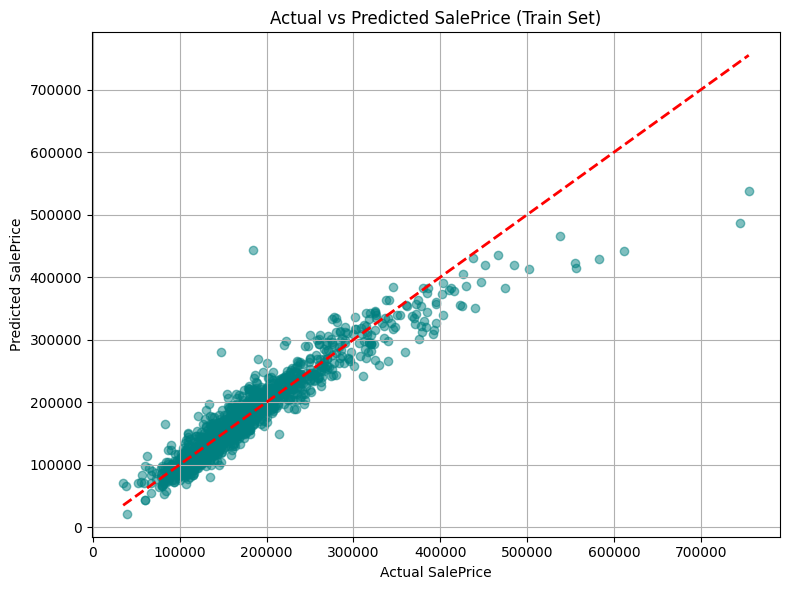

In [144]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_train, pred_train, alpha=0.5, color='teal')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='red', lw=2, linestyle='--')  # perfect prediction line
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Train Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

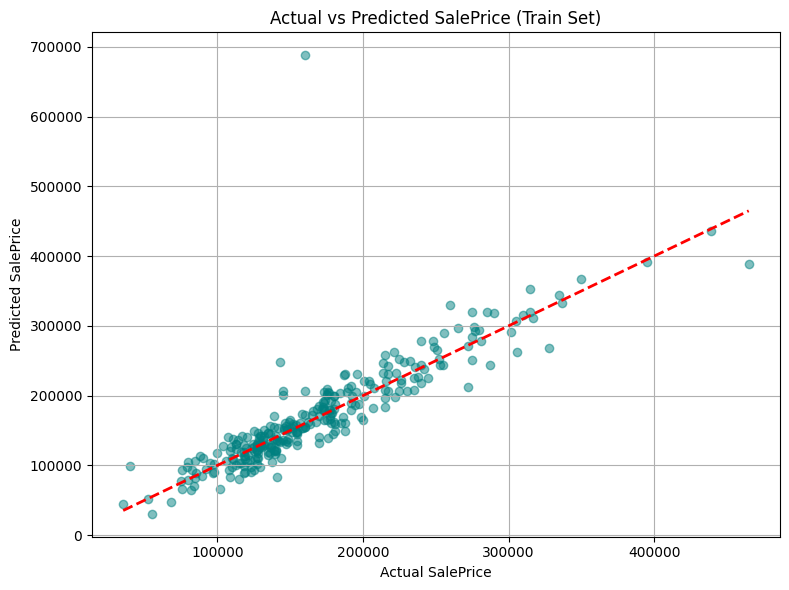

In [145]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_cv, pred_cv, alpha=0.5, color='teal')
plt.plot([Y_cv.min(), Y_cv.max()], [Y_cv.min(), Y_cv.max()], color='red', lw=2, linestyle='--')  # perfect prediction line
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Train Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### From here we can see that a single data point caused the cv score to drop significantly, this data point will be investigated and likely dropped or modified


In [146]:
X_try = X_cv.copy()

In [147]:
X_try

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
541,542,0.235294,0.202055,0.044548,0.777778,0.428571,0.927536,0.833333,0.045000,0.666667,...,0,0,0,0,0,0,0,0,1,0
760,761,0.000000,0.167808,0.035660,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
49,50,0.000000,0.154110,0.029307,0.444444,0.714286,0.681159,0.266667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1390,1391,0.000000,0.167808,0.035660,0.666667,0.428571,0.927536,0.833333,0.152500,0.666667,...,0,0,0,0,0,0,0,0,1,0
143,144,0.000000,0.195205,0.041437,0.666667,0.428571,0.920290,0.816667,0.114375,0.666667,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,577,0.176471,0.106164,0.022524,0.666667,0.714286,0.405797,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1274,1275,0.176471,0.109589,0.018174,0.444444,0.571429,0.275362,0.883333,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
1301,1302,0.294118,0.133562,0.028175,0.555556,0.714286,0.507246,0.000000,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0
719,720,0.000000,0.164384,0.039496,0.444444,0.571429,0.702899,0.316667,0.000000,0.333333,...,0,0,0,0,0,0,0,0,1,0


In [148]:
pred_cv

array([278482.24276582, 110271.08347424, 129196.30710077, 224758.28274997,
       220592.48571016, 352275.49132647, 344454.88178132, 165498.46353061,
       113151.6538872 , 126438.99560238, 231109.78139236, 205941.5705902 ,
       156507.82330055, 147632.08358097, 129391.31261105, 278383.34088893,
       117531.86303111, 208182.82473904, 292678.45828099, 144755.58509894,
       144812.03020553, 311475.45431292, 129681.24822617, 153829.12530992,
       207051.23208061, 318485.52776184, 113578.53865952, 243680.70879347,
       252550.93294938, 136980.6110001 , 211882.08736139, 104399.07973799,
       109314.63305127, 147903.82943492, 206372.77953442, 162535.93072331,
       130219.83795239, 124409.65477078, 179960.28189662, 217931.57952   ,
        97604.67729595,  82712.56785457, 146467.4366734 , 116804.93397945,
       207264.08677596, 133844.92607888, 198827.99376337, 133125.407054  ,
       106966.66503935, 126350.65966668, 284510.01560181, 200629.7223    ,
       203401.99559045, 3

In [149]:
X_try['pred_cv'] = pred_cv

In [150]:
Y_cv

541     248000
760     127500
49      127000
1390    235000
143     204000
         ...  
576     145000
1274    139000
1301    177500
719     128500
256     207500
Name: SalePrice, Length: 290, dtype: int64

In [151]:
X_try['actual price'] = Y_cv

In [152]:
pd.set_option('display.max_columns', None)

In [153]:
X_try[X_try['pred_cv']>500000]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_OtherMisc,MiscFeature_Shed,Alley_NoAlley,Alley_Pave,MasVnrType_BrkFace,MasVnrType_Stone,MSZoning_FV,MSZoning_RH,MSZoning_RL,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_ImStucc,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock,pred_cv,actual price
1298,1299,0.235294,1.0,0.291952,1.0,0.428571,0.985507,0.966667,0.4975,1.0,0.5,1.0,0.75,1.0,1.0,2.497345,0.166667,0.0,0.199486,1.905802,1.0,1,1.0,0.0,1.222478,0.666667,0.0,0.666667,0.5,0.5,0.0,1.0,1.0,1.0,1.0,1.045723,0.6,0.249708,0.558317,0.0,0.0,0.0,0.740741,0.0,0.0,0.0,0.5,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,688043.459957,160000


Droping id 1298 as its an outlier, and it drops the cv score by over 20%
The id 1298, is a 2story built in 2008 and has alot of feature, being sold for 160k which is the lowest, the price of the house is exteremly cheap so its better we remove it as for now i believe it act as an anomaly 

In [154]:
X_try.drop([1298], inplace=True)

In [155]:
X_try

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_OtherMisc,MiscFeature_Shed,Alley_NoAlley,Alley_Pave,MasVnrType_BrkFace,MasVnrType_Stone,MSZoning_FV,MSZoning_RH,MSZoning_RL,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_ImStucc,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock,pred_cv,actual price
541,542,0.235294,0.202055,0.044548,0.777778,0.428571,0.927536,0.833333,0.045000,0.666667,0.5,0.8,0.75,0.25,0.166667,0.000000,0.166667,0.0,0.414812,0.302246,1.00,1,1.0,0.0,0.449332,0.000000,0.0,0.666667,0.5,0.666667,0.0,0.666667,1.0,0.333333,1.000000,0.477876,0.6,0.000000,0.107075,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.454545,0.25,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,278482.242766,248000
760,761,0.000000,0.167808,0.035660,0.555556,0.571429,0.630435,0.150000,0.000000,0.333333,0.5,0.6,0.75,0.25,0.500000,0.270796,0.166667,0.0,0.107877,0.269495,1.00,1,1.0,0.0,0.122064,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.333333,1.0,0.000000,0.333333,0.221239,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.054217,0.818182,0.75,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [156]:
Y_try = X_try['actual price']

In [157]:
X_try[['actual price', 'pred_cv']]

,actual price,pred_cv
541,248000,278482.242766
760,127500,110271.083474
49,127000,129196.307101
1390,235000,224758.282750
143,204000,220592.485710
...,...,...
576,145000,137052.621175
1274,139000,155435.184775
1301,177500,170318.061584
719,128500,139258.477373


In [158]:
del X_try['actual price']

In [159]:
del X_try['pred_cv']

#### We can see the significant increase in the cv score after that data point was removed

In [160]:
report("Cross validation II, This is done after the outlier is removed", X_try, Y_try)

Cross validation II, This is done after the outlier is removed →  RMSE: 21936.90,  R²: 0.885


In [161]:
report_ridge("Cross validation II, This is done after the outlier is removed", X_try, Y_try)

Cross validation II, This is done after the outlier is removed →  RMSE: 21206.30,  R²: 0.893, →  RMSElog: 0.14


In [162]:
report_ridge1("Cross validation II, This is done after the outlier is removed", X_try, Y_try)

After feature selection → RMSE: 15934.99, RMSELog: 0.11, R²: 0.939


In [163]:
pred_try = ridge1.predict(X_try[selected_feats])

In [164]:
df_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [165]:
X_test1

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_OtherMisc,MiscFeature_Shed,Alley_NoAlley,Alley_Pave,MasVnrType_BrkFace,MasVnrType_Stone,MSZoning_FV,MSZoning_RH,MSZoning_RL,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_ImStucc,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Exterior2nd_CBlock
0,1461,0.000000,0.202055,0.047458,0.444444,0.571429,0.644928,0.183333,0.00000,0.333333,0.5,0.6,0.75,0.25,0.500000,0.207080,0.333333,0.097693,0.115582,0.275109,0.50,1,1.0,0.0,0.129433,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.333333,1.0,0.000000,0.333333,0.538348,0.6,0.163361,0.000000,0.0,0.0,0.272727,0.0,0.75,0.000000,0.454545,1.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1462,0.000000,0.205479,0.059831,0.555556,0.571429,0.623188,0.133333,0.06750,0.333333,0.5,0.6,0.75,0.25,0.833333,0.408407,0.166667,0.000000,0.173801,0.414535,0.50,1,1.0,0.0,0.229157,0.000000,0.0,0.333333,0.5,0.500000,0.0,0.666667,1.0,0.000000,0.333333,0.230088,0.6,0.458576,0.068834,0.0,0.0,0.000000,0.0,0.00,1.506024,0.454545,1.0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1

In [166]:
#pred_test1 = ridge_model.predict(X_test1.drop(['Id'], axis=1))

In [167]:
pred_ridge1_test = ridge1.predict(X_test1[selected_feats])

In [168]:
len(pred_ridge1_test)

1459

In [169]:
pred_ridge1_test

array([11.68328894, 11.97634294, 12.08578483, ..., 11.96084202,
       11.67250301, 12.31353928])

In [170]:
submission = pd.DataFrame()

In [171]:
submission['Id'] = X_test1['Id']

In [172]:
submission['SalePrice'] = np.expm1(pred_ridge1_test)

In [173]:
submission

,Id,SalePrice
0,1461,118572.575395
1,1462,158948.677434
2,1463,177332.040516
3,1464,200306.179793
4,1465,201906.303511
...,...,...
1454,2915,91981.421890
1455,2916,89267.409044
1456,2917,156503.810175
1457,2918,117300.522025


In [174]:
submission.to_csv('submission.csv', index=False)

In [175]:
submission.to_csv('Submission/submission.csv', index=False)


In [176]:
submission

,Id,SalePrice
0,1461,118572.575395
1,1462,158948.677434
2,1463,177332.040516
3,1464,200306.179793
4,1465,201906.303511
...,...,...
1454,2915,91981.421890
1455,2916,89267.409044
1456,2917,156503.810175
1457,2918,117300.522025
